In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline # Use the imblearn pipeline
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency, f_oneway, jarque_bera, probplot

In [2]:
df = pd.read_csv('train.csv')
a1=df.copy()

In [3]:
# Dropping useless columns
a1 = a1.drop(columns=['customer_id',	'name'	])

In [4]:
num_cols = a1.columns[[0,4,5,6,8,10,11,12,13]].tolist()
cat_cols = [col for col in a1.columns.tolist() if col not in num_cols]

In [5]:


# Chi-squared Test: Categorical vs Categorical
def chi_2_test(dataframe, col1, col2, alpha=0.05):
    data = dataframe[[col1, col2]].dropna()

    # create contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # perform chi-squared test
    _, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"P-value: {p_val:.4f}")

    if p_val <= alpha:
        print(f"Reject the null hypothesis. There is a significant association between '{col1}' and '{col2}'.")
    else:
        print(f"Fail to reject the null hypothesis. No significant association between '{col1}' and '{col2}'.")

# ANOVA Test: Numerical vs Categorical
def anova_test(dataframe, num_col, cat_col, alpha=0.05):
    data = dataframe[[num_col, cat_col]].dropna()

    cat_group = data.groupby(cat_col)
    groups = [group[num_col].values for _, group in cat_group]

    f_stat, p_val = f_oneway(*groups)
    print(f"P-value: {p_val:.4f}")

    if p_val <= alpha:
        print(f"Reject the null hypothesis. '{num_col}' varies significantly across '{cat_col}'.")
    else:
        print(f"Fail to reject the null hypothesis. '{num_col}' does not vary significantly across '{cat_col}'.")


In [6]:
for i in cat_cols:
    chi_2_test(a1,i,'credit_card_default')

P-value: 0.0000
Reject the null hypothesis. There is a significant association between 'gender' and 'credit_card_default'.
P-value: 0.0003
Reject the null hypothesis. There is a significant association between 'owns_car' and 'credit_card_default'.
P-value: 0.5782
Fail to reject the null hypothesis. No significant association between 'owns_house' and 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. There is a significant association between 'occupation_type' and 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. There is a significant association between 'migrant_worker' and 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. There is a significant association between 'prev_defaults' and 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. There is a significant association between 'default_in_last_6months' and 'credit_card_default'.


ValueError: Data must be 1-dimensional, got ndarray of shape (45528, 2) instead

In [7]:
for i in num_cols:
    anova_test(a1,i,'credit_card_default')

P-value: 0.8339
Fail to reject the null hypothesis. 'age' does not vary significantly across 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. 'no_of_children' varies significantly across 'credit_card_default'.
P-value: 0.0141
Reject the null hypothesis. 'net_yearly_income' varies significantly across 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. 'no_of_days_employed' varies significantly across 'credit_card_default'.
P-value: 0.0219
Reject the null hypothesis. 'total_family_members' varies significantly across 'credit_card_default'.
P-value: 0.0053
Reject the null hypothesis. 'yearly_debt_payments' varies significantly across 'credit_card_default'.
P-value: 0.0090
Reject the null hypothesis. 'credit_limit' varies significantly across 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. 'credit_limit_used(%)' varies significantly across 'credit_card_default'.
P-value: 0.0000
Reject the null hypothesis. 'credit_score' varies significan

In [8]:
# Dropping occupation type column
a1=a1.drop(columns='occupation_type')

In [9]:
a1['gender'] = a1['gender'].replace('XNA', 'M')

In [10]:
a1['gender'].value_counts()

gender
F    29957
M    15571
Name: count, dtype: int64

# Dropping Missing Missing Values

In [52]:
a1_no_missing = a1.dropna()

In [53]:
a1_no_missing.isna().sum()

age                        0
gender                     0
owns_car                   0
owns_house                 0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

In [54]:
X = a1_no_missing.drop(columns='credit_card_default')
y = a1_no_missing['credit_card_default']

<Axes: xlabel='credit_card_default'>

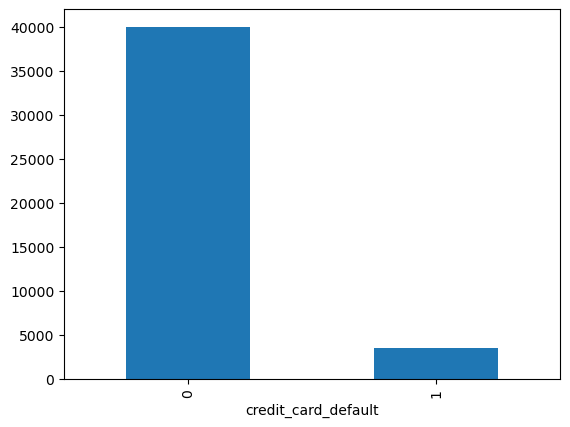

In [55]:
y.value_counts().plot(kind='bar')

In [56]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [57]:
print('The size of train data is',X_train.shape)
print('The size of test data is',X_test.shape)

The size of train data is (34807, 15)
The size of test data is (8702, 15)


In [58]:
a1_no_missing.columns

Index(['age', 'gender', 'owns_car', 'owns_house', 'no_of_children',
       'net_yearly_income', 'no_of_days_employed', 'total_family_members',
       'migrant_worker', 'yearly_debt_payments', 'credit_limit',
       'credit_limit_used(%)', 'credit_score', 'prev_defaults',
       'default_in_last_6months', 'credit_card_default'],
      dtype='object')

In [59]:
a1_no_missing.head(5)

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,46,F,N,Y,0.0,107934.04,612.0,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,29,M,N,Y,0.0,109862.62,2771.0,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,37,M,N,Y,0.0,230153.17,204.0,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,39,F,N,Y,0.0,122325.82,11941.0,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,46,M,Y,Y,0.0,387286.00,1459.0,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [60]:
# Basic Preprocessing
num_colss = ['age','no_of_children','net_yearly_income','no_of_days_employed','total_family_members','yearly_debt_payments','credit_limit','credit_limit_used(%)','credit_score']
nominal_cat_cols = ['gender' , 'owns_car' , 'owns_house']

In [61]:
# 1. Build the preprocessor
preprocessor1 = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), num_colss),
        ("nominal_encode", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),
    ],
    remainder="passthrough",
    n_jobs=-1,
    
)
preprocessor1.set_output(transform="pandas")


ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 ['age', 'no_of_children', 'net_yearly_income',
                                  'no_of_days_employed', 'total_family_members',
                                  'yearly_debt_payments', 'credit_limit',
                                  'credit_limit_used(%)', 'credit_score']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['gender', 'owns_car', 'owns_house'])])

In [62]:
# 2. Define the other steps for the pipeline
smote = SMOTE(random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)



full_pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('smote', smote),
    ('model', model)
])


In [63]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


cv_results = cross_validate(
    full_pipeline1,    
    X_train,          
    y_train,          
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False
)


print("CV Results:")
print(f"Accuracy     : {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision    : {cv_results['test_precision'].mean():.4f}")
print(f"Recall       : {cv_results['test_recall'].mean():.4f}")
print(f"F1-score     : {cv_results['test_f1'].mean():.4f}")
print(f"ROC-AUC      : {cv_results['test_roc_auc'].mean():.4f}")



CV Results:
Accuracy     : 0.9500
Precision    : 0.6208
Recall       : 0.9567
F1-score     : 0.7529
ROC-AUC      : 0.9928


--- Final Model Performance on Test Data ---
Accuracy: 0.9522
F1-Score: 0.7801

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      7942
           1       0.65      0.97      0.78       760

    accuracy                           0.95      8702
   macro avg       0.82      0.96      0.88      8702
weighted avg       0.97      0.95      0.96      8702


--- Confusion Matrix ---


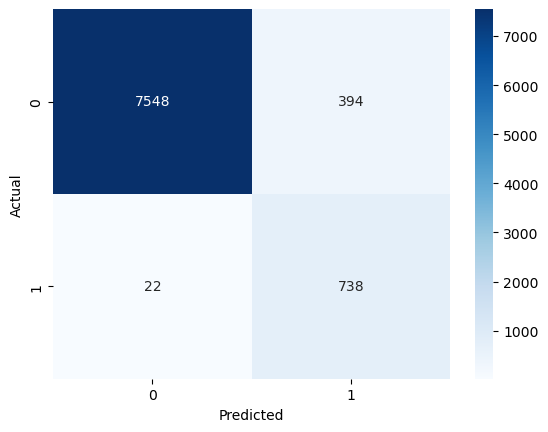

In [64]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
full_pipeline1.fit(X_train, y_train)


y_pred = full_pipeline1.predict(X_test)

print("--- Final Model Performance on Test Data ---")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Impute Missing Values

In [65]:
a1_impute = a1.copy()

In [66]:
X = a1_impute.drop(columns='credit_card_default')
y = a1_impute['credit_card_default']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [68]:
X_train.columns

Index(['age', 'gender', 'owns_car', 'owns_house', 'no_of_children',
       'net_yearly_income', 'no_of_days_employed', 'total_family_members',
       'migrant_worker', 'yearly_debt_payments', 'credit_limit',
       'credit_limit_used(%)', 'credit_score', 'prev_defaults',
       'default_in_last_6months'],
      dtype='object')

In [69]:
X_train.isna().sum()

age                          0
gender                       0
owns_car                   441
owns_house                   0
no_of_children             624
net_yearly_income            0
no_of_days_employed        361
total_family_members        70
migrant_worker              73
yearly_debt_payments        73
credit_limit                 0
credit_limit_used(%)         0
credit_score                 6
prev_defaults                0
default_in_last_6months      0
dtype: int64

<Axes: xlabel='owns_car'>

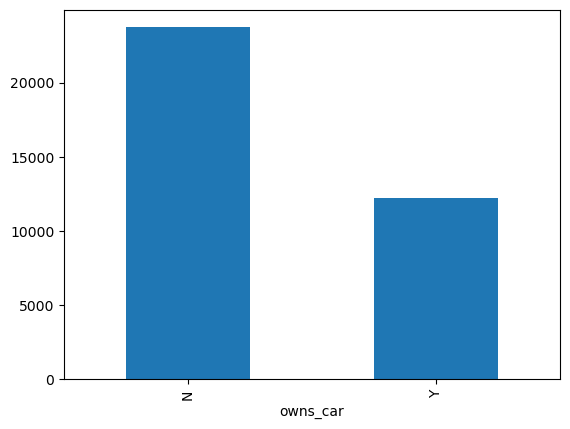

In [70]:
X_train['owns_car'].value_counts().plot(kind='bar')

<Axes: xlabel='migrant_worker'>

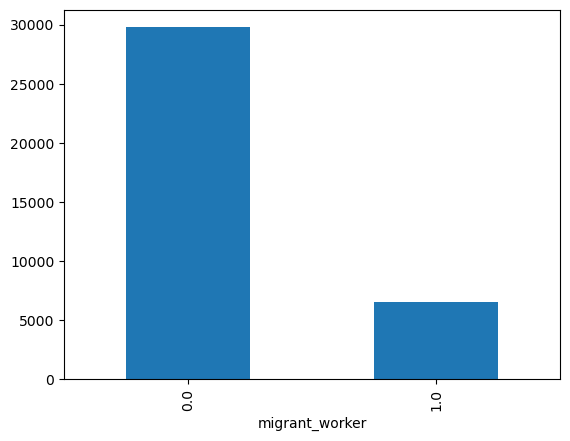

In [71]:
X_train['migrant_worker'].value_counts().plot(kind='bar')

These two cols can be imputed through mode, as one category is clearly dominating.

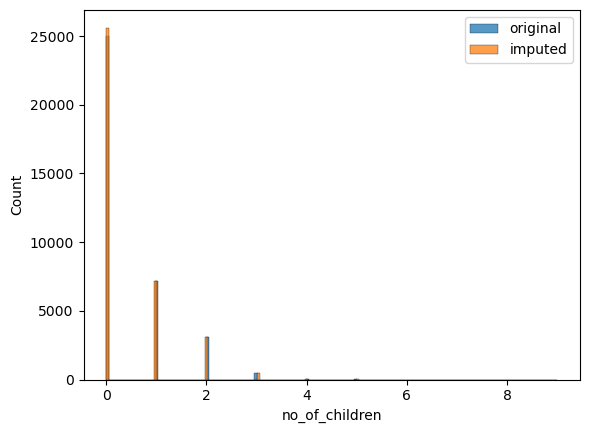

In [72]:
sns.histplot(X_train['no_of_children'],label='original')
sns.histplot(X_train['no_of_children'].fillna(X_train['no_of_children'].median()),label='imputed')
plt.legend()

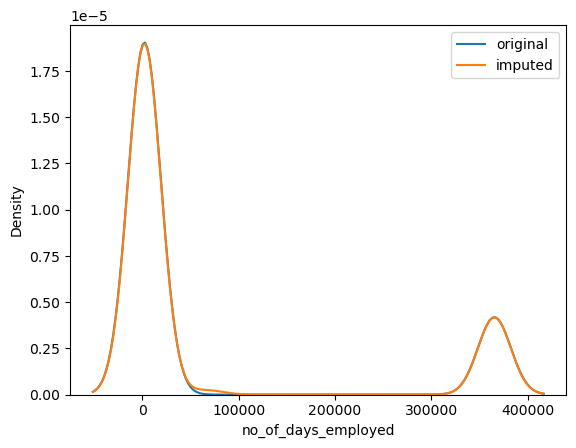

In [73]:

sns.kdeplot(X_train['no_of_days_employed'],label = 'original')
sns.kdeplot(X_train['no_of_days_employed'].fillna(X_train['no_of_days_employed'].mean()),label='imputed')
plt.legend()

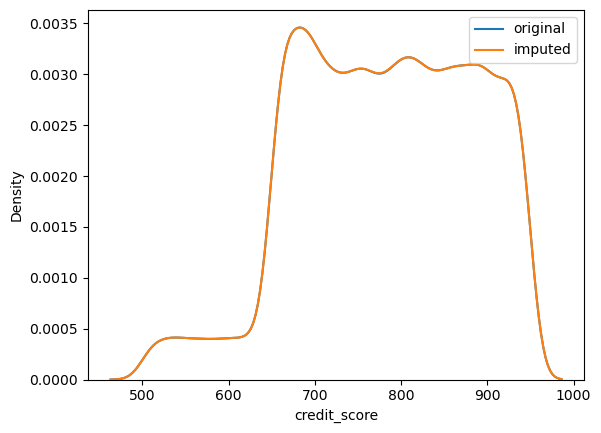

In [74]:
sns.kdeplot(X_train['credit_score'],label = 'original')

sns.kdeplot(X_train['credit_score'].fillna(X_train['credit_score'].mean()),label='imputed')
plt.legend()

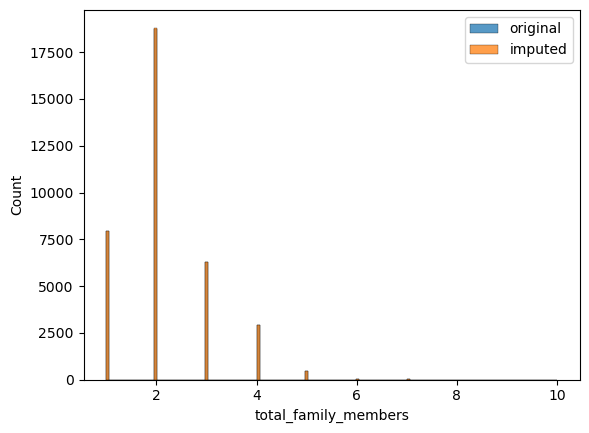

In [75]:
sns.histplot(X_train['total_family_members'],label='original')
sns.histplot(X_train['total_family_members'].fillna(X_train['total_family_members'].median()),label='imputed')
plt.legend()

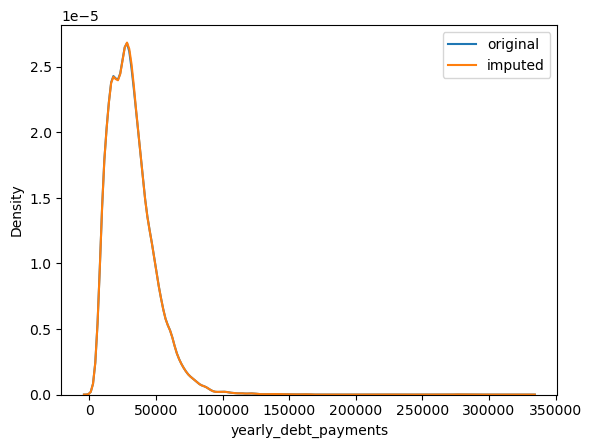

In [76]:
sns.kdeplot(X_train['yearly_debt_payments'],label = 'original')
sns.kdeplot(X_train['yearly_debt_payments'].fillna(X_train['yearly_debt_payments'].mean()),label='imputed')
plt.legend()

Imputation Pipeline

In [77]:
features_to_fill_mode = ['owns_car','migrant_worker',]
features_to_fill_median = ['no_of_children','total_family_members']
features_to_fill_mean = ['no_of_days_employed','yearly_debt_payments','credit_score']

In [78]:
simple_imputer = ColumnTransformer(
    transformers=[
        ('mode_imputer', SimpleImputer(strategy='most_frequent'), features_to_fill_mode),
        ('median_imputer', SimpleImputer(strategy='median'), features_to_fill_median),
        ('mean_imputer', SimpleImputer(strategy='mean'), features_to_fill_mean)
    ],
    remainder='passthrough',  # leave other columns as they are
    n_jobs=-1,
    verbose_feature_names_out=False
)
simple_imputer.set_output(transform="pandas")

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('mode_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['owns_car', 'migrant_worker']),
                                ('median_imputer',
                                 SimpleImputer(strategy='median'),
                                 ['no_of_children', 'total_family_members']),
                                ('mean_imputer', SimpleImputer(),
                                 ['no_of_days_employed', 'yearly_debt_payments',
                                  'credit_score'])],
                  verbose_feature_names_out=False)

In [79]:

# basic preprocessing
preprocessor2 = ColumnTransformer(transformers=[
    ("scale", StandardScaler(), num_colss),
    ("nominal_encode", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),

], remainder="passthrough", n_jobs=-1, force_int_remainder_cols=False, verbose_feature_names_out=False)

preprocessor2.set_output(transform="pandas")

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 ['age', 'no_of_children', 'net_yearly_income',
                                  'no_of_days_employed', 'total_family_members',
                                  'yearly_debt_payments', 'credit_limit',
                                  'credit_limit_used(%)', 'credit_score']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['gender', 'owns_car', 'owns_house'])],
                  verbose_feature_names_out=False)

In [80]:
full_pipeline2 = Pipeline(steps=[
    
    ('imputer', simple_imputer),
    ('preprocessor', preprocessor2),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
full_pipeline2


Pipeline(steps=[('imputer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['owns_car',
                                                   'migrant_worker']),
                                                 ('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['no_of_children',
                                                   'total_family_members']),
                                                 ('mean_imputer',
                                                  SimpleImputer(),
                                                  ['no_of_days_employed',
                                                   'yearly_debt_payments...
                                                   'total_family_members',
                                                   'yearly_debt_payments',
                                                   'credit_limit',
                                                   'credit_limit_used(%)',
                                                   'credit_score']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'owns_car',
                                                   'owns_house'])],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


scoring_metrics = ['accuracy', 'f1']


cv_results = cross_validate(full_pipeline2, X_train, y_train,
                            cv=skf,
                            scoring=scoring_metrics)


print("--- Cross-Validation Performance ---")
print(f"Average Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Average F1-Score: {cv_results['test_f1'].mean():.4f}")

print("\n--- Scores for each fold ---")
print(f"Accuracy: {cv_results['test_accuracy']}")
print(f"F1-Score: {cv_results['test_f1']}")


--- Cross-Validation Performance ---
Average Accuracy: 0.9507
Average F1-Score: 0.7580

--- Scores for each fold ---
Accuracy: [0.94728895 0.95360329 0.95249863 0.95181219 0.94838001]
F1-Score: [0.74365821 0.77192982 0.76333789 0.76267748 0.74832664]


--- Final Model Performance on Test Data ---
Accuracy: 0.9550
F1-Score: 0.7819

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.97      8335
           1       0.66      0.95      0.78       771

    accuracy                           0.95      9106
   macro avg       0.83      0.95      0.88      9106
weighted avg       0.97      0.95      0.96      9106


--- Confusion Matrix ---


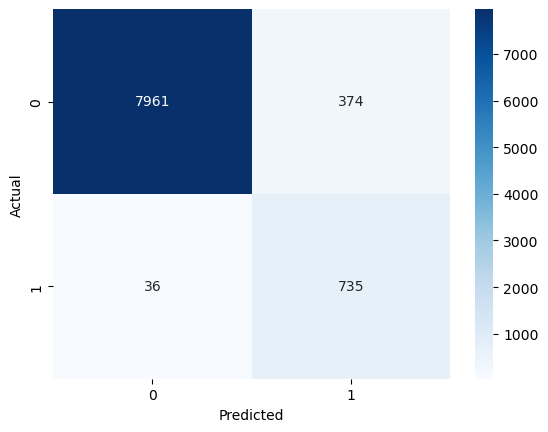

In [83]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


full_pipeline2.fit(X_train, y_train)


y_pred = full_pipeline2.predict(X_test)

print("--- Final Model Performance on Test Data ---")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Both models are performing equally good, but we will choose the model with imputed values as it has more observations thus adding more information to our model.